# Activity 4: KPI Analysis - Novel Mode vs Extended Mode

This notebook provides a comprehensive analysis comparing the Key Performance Indicators (KPIs) between **Novel Mode** (GNN-MARL) and **Extended Mode** in the Mountain Rescue Simulation.

## Objectives
1. Compare rescue efficiency between Novel and Extended modes
2. Analyze communication patterns and effectiveness
3. Evaluate agent coordination and response times
4. Assess learning progression in Novel Mode
5. Identify optimal operational scenarios for each mode

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Import simulation components - updated for new location
import sys
import os
src_path = os.path.join(os.path.dirname(os.getcwd()), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

from model import MountainRescueModel
from agents import FirstAidRobot, ExplorerDrone, Person

# Try to import GNN-MARL components
try:
    from gnn_marl import GNN_MARL_System, GNNConfig, MARLConfig
    NOVEL_MODE_AVAILABLE = True
    print("✅ Novel Mode (GNN-MARL) components available")
except ImportError as e:
    NOVEL_MODE_AVAILABLE = False
    print(f"⚠️ Novel Mode not available: {e}")
    print("📝 Analysis will focus on Extended Mode vs Basic Mode comparison")

print(f"📊 Analysis started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Novel Mode (GNN-MARL) components available
📊 Analysis started at 2025-07-15 14:05:06


## Configuration and Setup

In [2]:
# Simulation parameters
SIMULATION_CONFIG = {
    'width': 15,
    'height': 15,
    'n_robots': 4,
    'n_drones': 3,
    'n_persons': 8,
    'spawn_interval': 25,
    'max_persons': 20,
    'steps_per_run': 200,
    'num_runs': 5,  # Number of independent runs for statistical significance
    'seed_base': 42
}

print("🔧 Simulation Configuration:")
for key, value in SIMULATION_CONFIG.items():
    print(f"   {key}: {value}")

# Define KPIs to track
KPI_METRICS = [
    'Rescued',
    'Total Persons',
    'Rescue Rate',
    'Messages_Sent',
    'Average_Response_Time',
    'Communication_Efficiency',
    'Active Robots',
    'Active Drones',
    'Robots_Waiting',
    'Robots_On_Mission'
]

if NOVEL_MODE_AVAILABLE:
    NOVEL_KPI_METRICS = [
        'Novel_Robot_Epsilon',
        'Novel_Drone_Epsilon', 
        'Novel_Training_Steps'
    ]
    KPI_METRICS.extend(NOVEL_KPI_METRICS)

print(f"\n📈 Tracking {len(KPI_METRICS)} KPI metrics")

🔧 Simulation Configuration:
   width: 15
   height: 15
   n_robots: 4
   n_drones: 3
   n_persons: 8
   spawn_interval: 25
   max_persons: 20
   steps_per_run: 200
   num_runs: 5
   seed_base: 42

📈 Tracking 13 KPI metrics


## Simulation Runner Functions

In [3]:
def run_simulation(mode, run_id, config):
    """
    Run a single simulation instance
    
    Args:
        mode: 'extended' or 'novel'
        run_id: Unique identifier for this run
        config: Simulation configuration dictionary
    
    Returns:
        DataFrame with collected data
    """
    print(f"🔄 Running {mode} mode simulation #{run_id}...")
    
    # Create model with unique seed
    seed = config['seed_base'] + run_id * 100
    
    model = MountainRescueModel(
        width=config['width'],
        height=config['height'],
        n_robots=config['n_robots'],
        n_drones=config['n_drones'],
        n_persons=config['n_persons'],
        mode=mode,
        spawn_interval=config['spawn_interval'],
        max_persons=config['max_persons'],
        seed=seed
    )
    
    # Run simulation
    for step in range(config['steps_per_run']):
        model.step()
        
        # Print progress every 50 steps
        if (step + 1) % 50 == 0:
            rescued = model.rescued_count
            total_persons = len([a for a in model.agents if isinstance(a, Person)])
            print(f"   Step {step + 1}: {rescued}/{total_persons} persons rescued")
    
    # Extract data
    data = model.datacollector.get_model_vars_dataframe()
    data['Mode'] = mode
    data['Run_ID'] = run_id
    data['Step'] = data.index
    
    # Calculate final statistics
    final_stats = {
        'rescued_final': model.rescued_count,
        'total_persons_final': len([a for a in model.agents if isinstance(a, Person)]),
        'rescue_rate_final': model.rescued_count / max(1, len([a for a in model.agents if isinstance(a, Person)])),
        'messages_total': model.message_system.total_messages_sent if model.message_system else 0,
        'persons_spawned_dynamically': getattr(model, 'persons_spawned_dynamically', 0)
    }
    
    print(f"   ✅ Final: {final_stats['rescued_final']} rescued, {final_stats['messages_total']} messages")
    
    return data, final_stats

def run_mode_comparison(config):
    """
    Run complete comparison between modes
    
    Returns:
        all_data: Combined DataFrame with all simulation data
        summary_stats: Summary statistics by mode
    """
    all_data = []
    summary_stats = []
    
    # Define modes to test
    modes_to_test = ['extended']
    if NOVEL_MODE_AVAILABLE:
        modes_to_test.append('novel')
    
    for mode in modes_to_test:
        print(f"\n🚀 Starting {mode.upper()} mode analysis...")
        
        mode_data = []
        mode_final_stats = []
        
        for run_id in range(config['num_runs']):
            try:
                data, final_stats = run_simulation(mode, run_id, config)
                mode_data.append(data)
                
                # Add mode and run info to final stats
                final_stats['mode'] = mode
                final_stats['run_id'] = run_id
                mode_final_stats.append(final_stats)
                
            except Exception as e:
                print(f"   ❌ Run {run_id} failed: {e}")
                continue
        
        # Combine data for this mode
        if mode_data:
            mode_combined = pd.concat(mode_data, ignore_index=True)
            all_data.append(mode_combined)
            
            # Calculate summary statistics
            summary_stats.extend(mode_final_stats)
            
            print(f"   ✅ {mode.upper()} mode completed: {len(mode_data)} successful runs")
    
    # Combine all data
    combined_data = pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()
    summary_df = pd.DataFrame(summary_stats)
    
    return combined_data, summary_df

## Run Simulations

In [4]:
# Execute simulations
print("🎯 Starting comprehensive mode comparison...")
start_time = datetime.now()

simulation_data, summary_data = run_mode_comparison(SIMULATION_CONFIG)

end_time = datetime.now()
duration = (end_time - start_time).total_seconds()
print(f"\n⏱️ Total execution time: {duration:.1f} seconds")
print(f"📊 Collected {len(simulation_data)} data points across {len(summary_data)} runs")

🎯 Starting comprehensive mode comparison...

🚀 Starting EXTENDED mode analysis...
🔄 Running extended mode simulation #0...
🆘 Spawned 8 persons across the mountain
🏔️ Mountain Rescue Model initialized:
   Mode: extended
   Grid: 15x15
   Agents: 4 robots, 3 drones, 8 persons
   Base: (0, 0)
   Dynamic spawning: Every 25 steps (max 20 persons)
🟦 Robot 3: IDLE → WAITING_FOR_MISSION
🟦 Drone 6: IDLE → FLYING (Starting reconnaissance)
🟦 Drone 5: IDLE → FLYING (Starting reconnaissance)
🟦 Robot 4: IDLE → WAITING_FOR_MISSION
🟦 Robot 2: IDLE → WAITING_FOR_MISSION
🟦 Robot 1: IDLE → WAITING_FOR_MISSION
🟦 Drone 7: IDLE → FLYING (Starting reconnaissance)
🏠 Robot 4: No missions - staying at base waiting for drone coordinates
🏠 Robot 2: No missions - staying at base waiting for drone coordinates
✈️ Drone 6: FLYING reconnaissance at (0, 0) (Battery: 150)
✈️ Drone 6: Flying (0, 0) → (0, 1) (Alt: 0.0K MASL, Battery: 148)
✈️ Drone 7: FLYING reconnaissance at (0, 0) (Battery: 150)
✈️ Drone 7: Flying (0, 0)

## Data Overview and Summary Statistics

In [5]:
# Display data overview
print("📋 SIMULATION DATA OVERVIEW")
print("=" * 50)

if not simulation_data.empty:
    print(f"Total data points: {len(simulation_data)}")
    print(f"Modes tested: {simulation_data['Mode'].unique()}")
    print(f"Runs per mode: {simulation_data['Run_ID'].nunique()}")
    print(f"Steps per run: {simulation_data['Step'].max() + 1}")
    
    # Show sample data
    print("\n📊 Sample Data:")
    display(simulation_data.head())
    
    # Summary statistics by mode
    print("\n📈 Summary Statistics by Mode:")
    display(summary_data.groupby('mode').agg({
        'rescued_final': ['mean', 'std', 'min', 'max'],
        'rescue_rate_final': ['mean', 'std'],
        'messages_total': ['mean', 'std'],
        'persons_spawned_dynamically': ['mean', 'std']
    }).round(3))
else:
    print("❌ No simulation data collected. Check for errors above.")

📋 SIMULATION DATA OVERVIEW
Total data points: 2010
Modes tested: ['extended' 'novel']
Runs per mode: 5
Steps per run: 201

📊 Sample Data:


,Rescued,Total Persons,Active Robots,Active Drones,Rescue Rate,Messages_Sent,Robots_Waiting,Robots_On_Mission,Average_Response_Time,Communication_Efficiency,Successful_Rescues,Average_Rescue_Time,High_Urgency_Rescues,Novel_Robot_Epsilon,Novel_Drone_Epsilon,Novel_Training_Steps,Mode,Run_ID,Step
0,0,8,4,3,0.0,0,0,0,0.0,0.0,0,0.0,0,0.0,0.0,0,extended,0,0
1,0,8,4,3,0.0,0,4,0,0.0,0.0,0,0.0,0,0.0,0.0,0,extended,0,1
2,0,8,4,3,0.0,0,4,0,0.0,0.0,0,0.0,0,0.0,0.0,0,extended,0,2
3,0,8,4,3,0.0,0,4,0,0.0,0.0,0,0.0,0,0.0,0.0,0,extended,0,3
4,0,8,4,3,0.0,0,4,0,0.0,0.0,0,0.0,0,0.0,0.0,0,extended,0,4



📈 Summary Statistics by Mode:


rescued_final                rescue_rate_final        messages_total  \
                  mean    std min max              mean    std           mean   
mode                                                                            
extended           6.4  0.894   5   7             0.308  0.041           21.8   
novel              1.4  0.894   1   3             0.069  0.046            8.2   

                 persons_spawned_dynamically         
             std                        mean    std  
mode                                                 
extended   3.493                        12.8  0.447  
novel     11.256                        12.6  0.548

## KPI Analysis: Rescue Efficiency

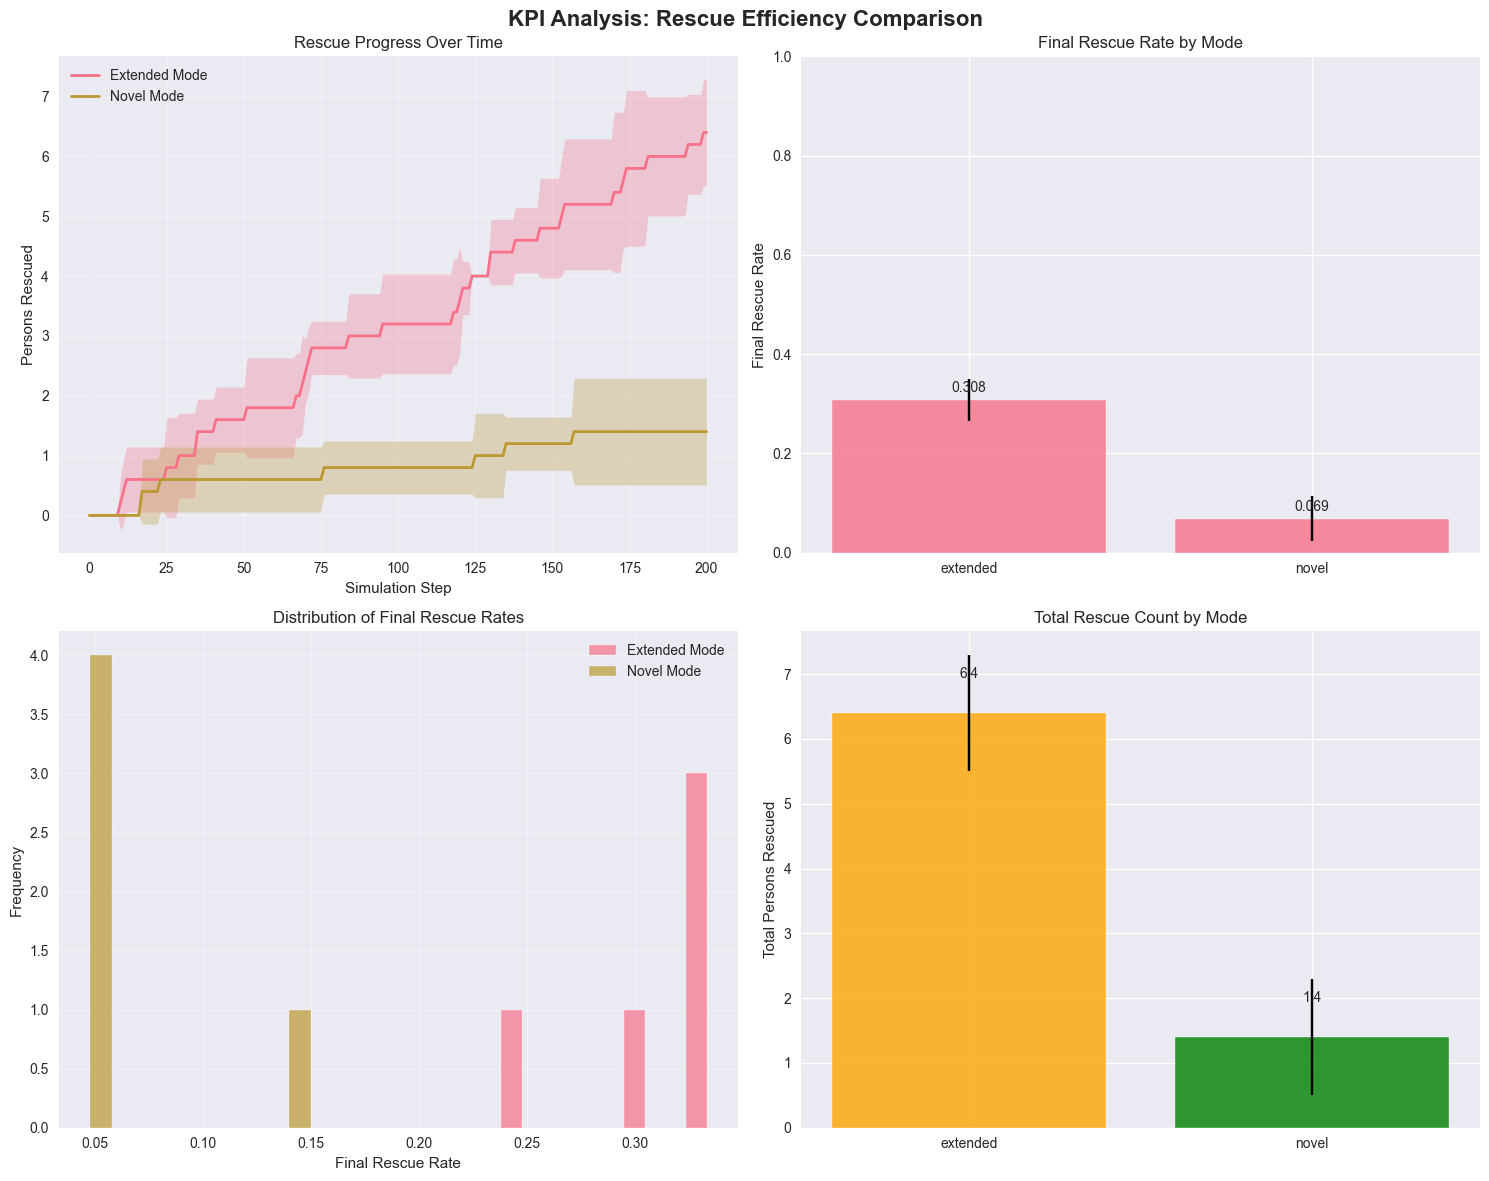


📊 RESCUE EFFICIENCY ANALYSIS
Extended Mode - Mean Rescue Rate: 0.308 ± 0.041
Novel Mode - Mean Rescue Rate: 0.069 ± 0.046

T-test: t=8.680, p=0.000
🏆 Extended Mode shows significantly better rescue efficiency (p < 0.05)


In [6]:
if not simulation_data.empty:
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('KPI Analysis: Rescue Efficiency Comparison', fontsize=16, fontweight='bold')
    
    # 1. Rescue Progress Over Time
    ax1 = axes[0, 0]
    for mode in simulation_data['Mode'].unique():
        mode_data = simulation_data[simulation_data['Mode'] == mode]
        
        # Calculate mean and std across runs
        rescue_stats = mode_data.groupby('Step')['Rescued'].agg(['mean', 'std']).reset_index()
        
        ax1.plot(rescue_stats['Step'], rescue_stats['mean'], label=f'{mode.title()} Mode', linewidth=2)
        ax1.fill_between(rescue_stats['Step'], 
                        rescue_stats['mean'] - rescue_stats['std'], 
                        rescue_stats['mean'] + rescue_stats['std'], 
                        alpha=0.3)
    
    ax1.set_xlabel('Simulation Step')
    ax1.set_ylabel('Persons Rescued')
    ax1.set_title('Rescue Progress Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Final Rescue Rates
    ax2 = axes[0, 1]
    rescue_rates = summary_data.groupby('mode')['rescue_rate_final'].agg(['mean', 'std']).reset_index()
    
    bars = ax2.bar(rescue_rates['mode'], rescue_rates['mean'], 
                   yerr=rescue_rates['std'], capsize=5, alpha=0.8)
    ax2.set_ylabel('Final Rescue Rate')
    ax2.set_title('Final Rescue Rate by Mode')
    ax2.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, mean_val in zip(bars, rescue_rates['mean']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{mean_val:.3f}', ha='center', va='bottom')
    
    # 3. Rescue Rate Distribution
    ax3 = axes[1, 0]
    for mode in summary_data['mode'].unique():
        mode_rates = summary_data[summary_data['mode'] == mode]['rescue_rate_final']
        ax3.hist(mode_rates, alpha=0.7, label=f'{mode.title()} Mode', bins=10)
    
    ax3.set_xlabel('Final Rescue Rate')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of Final Rescue Rates')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Total Persons Rescued
    ax4 = axes[1, 1]
    total_rescued = summary_data.groupby('mode')['rescued_final'].agg(['mean', 'std']).reset_index()
    
    bars = ax4.bar(total_rescued['mode'], total_rescued['mean'], 
                   yerr=total_rescued['std'], capsize=5, alpha=0.8, color=['orange', 'green'][:len(total_rescued)])
    ax4.set_ylabel('Total Persons Rescued')
    ax4.set_title('Total Rescue Count by Mode')
    
    # Add value labels on bars
    for bar, mean_val in zip(bars, total_rescued['mean']):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{mean_val:.1f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical significance test
    print("\n📊 RESCUE EFFICIENCY ANALYSIS")
    print("=" * 40)
    
    if len(summary_data['mode'].unique()) > 1:
        from scipy import stats
        
        modes = summary_data['mode'].unique()
        mode1_rates = summary_data[summary_data['mode'] == modes[0]]['rescue_rate_final']
        mode2_rates = summary_data[summary_data['mode'] == modes[1]]['rescue_rate_final']
        
        t_stat, p_value = stats.ttest_ind(mode1_rates, mode2_rates)
        
        print(f"{modes[0].title()} Mode - Mean Rescue Rate: {mode1_rates.mean():.3f} ± {mode1_rates.std():.3f}")
        print(f"{modes[1].title()} Mode - Mean Rescue Rate: {mode2_rates.mean():.3f} ± {mode2_rates.std():.3f}")
        print(f"\nT-test: t={t_stat:.3f}, p={p_value:.3f}")
        
        if p_value < 0.05:
            better_mode = modes[0] if mode1_rates.mean() > mode2_rates.mean() else modes[1]
            print(f"🏆 {better_mode.title()} Mode shows significantly better rescue efficiency (p < 0.05)")
        else:
            print("📊 No significant difference in rescue efficiency between modes")
else:
    print("❌ No data available for rescue efficiency analysis")

## KPI Analysis: Communication Effectiveness

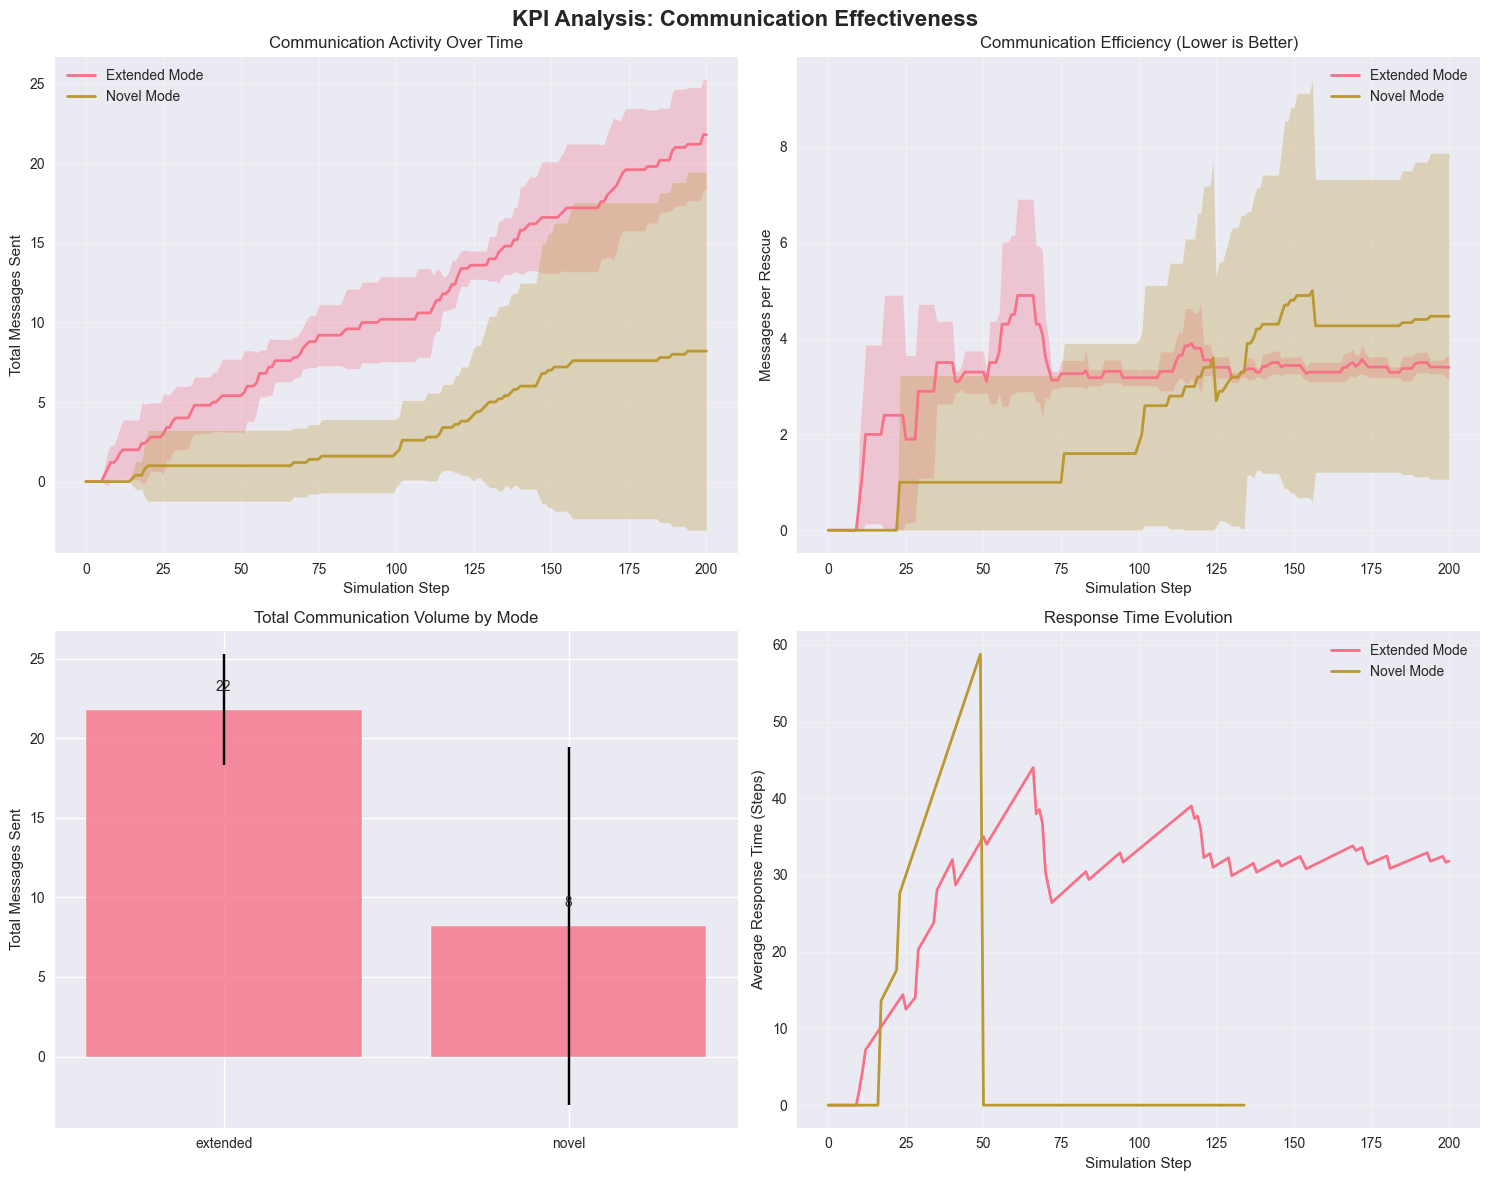


📡 COMMUNICATION EFFECTIVENESS ANALYSIS

Extended Mode:
  Average messages sent: 21.8
  Average persons rescued: 6.4
  Messages per rescue: 3.4

Novel Mode:
  Average messages sent: 8.2
  Average persons rescued: 1.4
  Messages per rescue: 5.9


In [7]:
if not simulation_data.empty:
    # Create figure for communication analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('KPI Analysis: Communication Effectiveness', fontsize=16, fontweight='bold')
    
    # 1. Messages Sent Over Time
    ax1 = axes[0, 0]
    for mode in simulation_data['Mode'].unique():
        mode_data = simulation_data[simulation_data['Mode'] == mode]
        
        # Calculate mean and std across runs
        msg_stats = mode_data.groupby('Step')['Messages_Sent'].agg(['mean', 'std']).reset_index()
        
        ax1.plot(msg_stats['Step'], msg_stats['mean'], label=f'{mode.title()} Mode', linewidth=2)
        ax1.fill_between(msg_stats['Step'], 
                        msg_stats['mean'] - msg_stats['std'], 
                        msg_stats['mean'] + msg_stats['std'], 
                        alpha=0.3)
    
    ax1.set_xlabel('Simulation Step')
    ax1.set_ylabel('Total Messages Sent')
    ax1.set_title('Communication Activity Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Communication Efficiency
    ax2 = axes[0, 1]
    for mode in simulation_data['Mode'].unique():
        mode_data = simulation_data[simulation_data['Mode'] == mode]
        
        # Filter out infinite values and calculate efficiency
        efficiency_data = mode_data[mode_data['Communication_Efficiency'] < 1000]  # Remove outliers
        eff_stats = efficiency_data.groupby('Step')['Communication_Efficiency'].agg(['mean', 'std']).reset_index()
        
        ax2.plot(eff_stats['Step'], eff_stats['mean'], label=f'{mode.title()} Mode', linewidth=2)
        ax2.fill_between(eff_stats['Step'], 
                        np.maximum(0, eff_stats['mean'] - eff_stats['std']), 
                        eff_stats['mean'] + eff_stats['std'], 
                        alpha=0.3)
    
    ax2.set_xlabel('Simulation Step')
    ax2.set_ylabel('Messages per Rescue')
    ax2.set_title('Communication Efficiency (Lower is Better)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Total Messages by Mode
    ax3 = axes[1, 0]
    total_messages = summary_data.groupby('mode')['messages_total'].agg(['mean', 'std']).reset_index()
    
    bars = ax3.bar(total_messages['mode'], total_messages['mean'], 
                   yerr=total_messages['std'], capsize=5, alpha=0.8)
    ax3.set_ylabel('Total Messages Sent')
    ax3.set_title('Total Communication Volume by Mode')
    
    # Add value labels on bars
    for bar, mean_val in zip(bars, total_messages['mean']):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{mean_val:.0f}', ha='center', va='bottom')
    
    # 4. Response Time Analysis
    ax4 = axes[1, 1]
    for mode in simulation_data['Mode'].unique():
        mode_data = simulation_data[simulation_data['Mode'] == mode]
        
        # Filter reasonable response times
        response_data = mode_data[mode_data['Average_Response_Time'] < 100]
        response_stats = response_data.groupby('Step')['Average_Response_Time'].agg(['mean', 'std']).reset_index()
        
        ax4.plot(response_stats['Step'], response_stats['mean'], label=f'{mode.title()} Mode', linewidth=2)
    
    ax4.set_xlabel('Simulation Step')
    ax4.set_ylabel('Average Response Time (Steps)')
    ax4.set_title('Response Time Evolution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Communication effectiveness summary
    print("\n📡 COMMUNICATION EFFECTIVENESS ANALYSIS")
    print("=" * 45)
    
    for mode in summary_data['mode'].unique():
        mode_summary = summary_data[summary_data['mode'] == mode]
        avg_messages = mode_summary['messages_total'].mean()
        avg_rescued = mode_summary['rescued_final'].mean()
        messages_per_rescue = avg_messages / max(1, avg_rescued)
        
        print(f"\n{mode.title()} Mode:")
        print(f"  Average messages sent: {avg_messages:.1f}")
        print(f"  Average persons rescued: {avg_rescued:.1f}")
        print(f"  Messages per rescue: {messages_per_rescue:.1f}")
        
else:
    print("❌ No data available for communication analysis")

## KPI Analysis: Agent Coordination

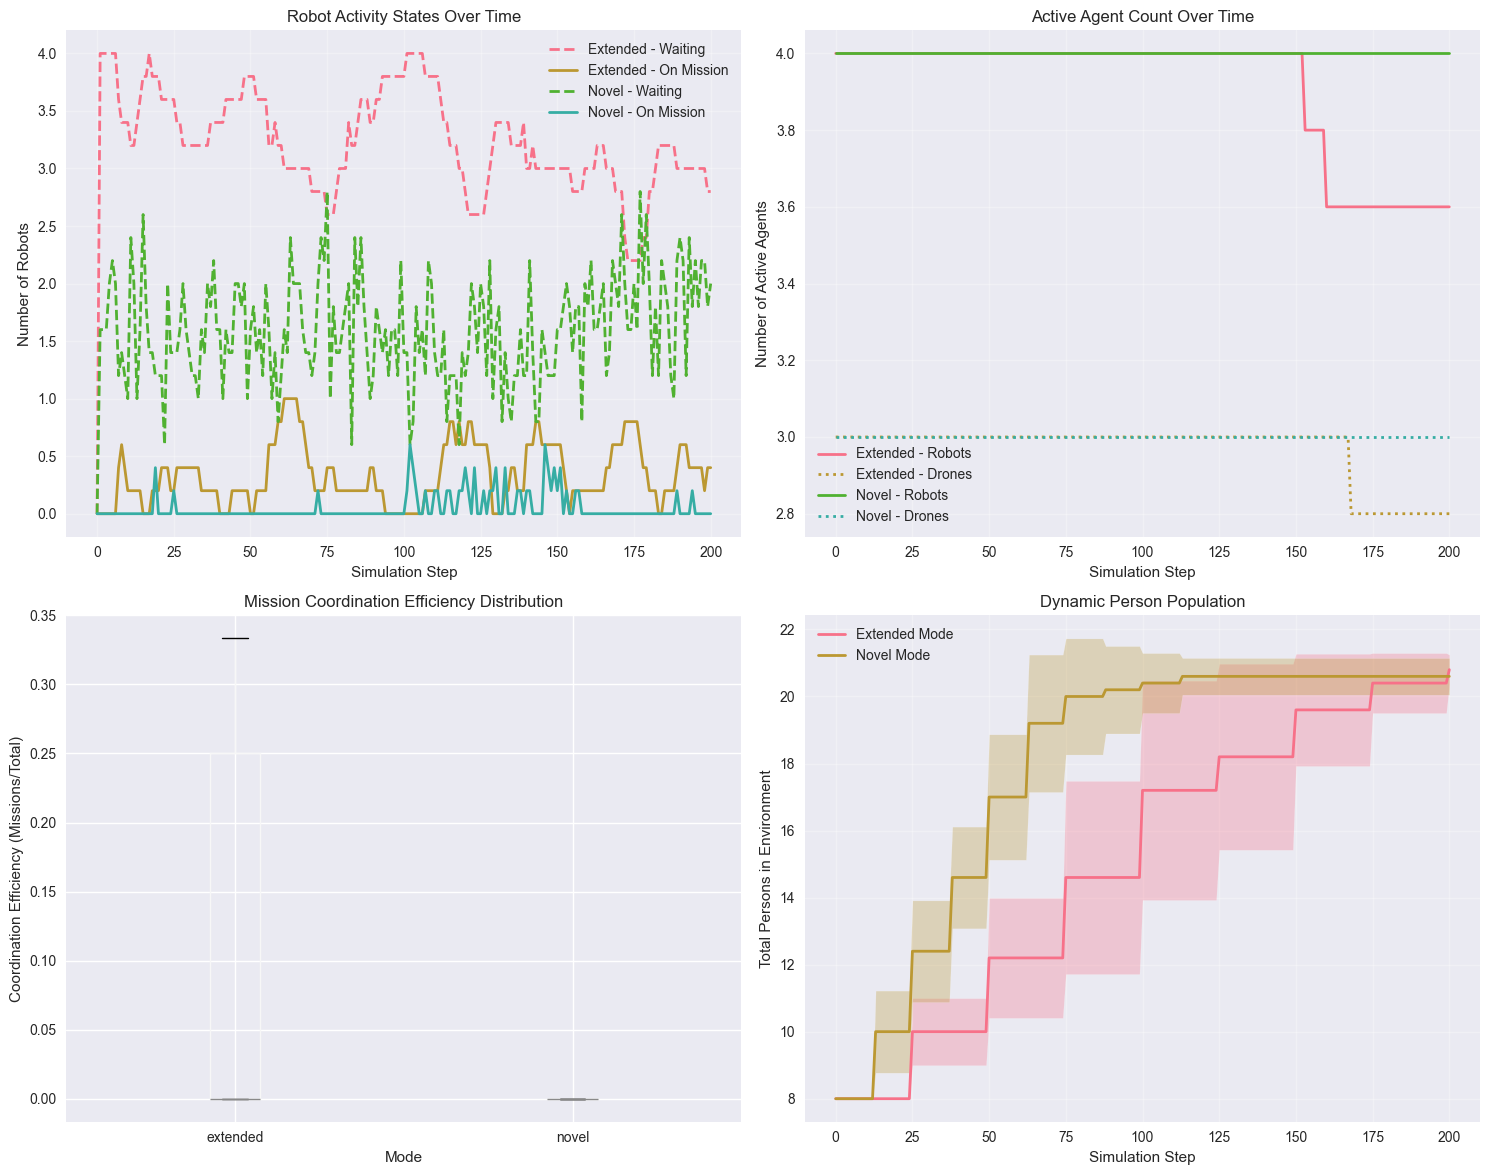


🤝 AGENT COORDINATION ANALYSIS

Extended Mode:
  Average robots waiting: 2.8
  Average robots on mission: 0.4
  Robot utilization rate: 12.5%
  Average active robots: 3.6
  Average active drones: 2.8

Novel Mode:
  Average robots waiting: 2.0
  Average robots on mission: 0.0
  Robot utilization rate: 0.0%
  Average active robots: 4.0
  Average active drones: 3.0


In [8]:
if not simulation_data.empty:
    # Create figure for coordination analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('KPI Analysis: Agent Coordination and Activity', fontsize=16, fontweight='bold')
    
    # 1. Robot States Over Time
    ax1 = axes[0, 0]
    for mode in simulation_data['Mode'].unique():
        mode_data = simulation_data[simulation_data['Mode'] == mode]
        
        waiting_stats = mode_data.groupby('Step')['Robots_Waiting'].agg(['mean']).reset_index()
        mission_stats = mode_data.groupby('Step')['Robots_On_Mission'].agg(['mean']).reset_index()
        
        ax1.plot(waiting_stats['Step'], waiting_stats['mean'], 
                label=f'{mode.title()} - Waiting', linestyle='--', linewidth=2)
        ax1.plot(mission_stats['Step'], mission_stats['mean'], 
                label=f'{mode.title()} - On Mission', linewidth=2)
    
    ax1.set_xlabel('Simulation Step')
    ax1.set_ylabel('Number of Robots')
    ax1.set_title('Robot Activity States Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Active Agents
    ax2 = axes[0, 1]
    for mode in simulation_data['Mode'].unique():
        mode_data = simulation_data[simulation_data['Mode'] == mode]
        
        robot_stats = mode_data.groupby('Step')['Active Robots'].agg(['mean']).reset_index()
        drone_stats = mode_data.groupby('Step')['Active Drones'].agg(['mean']).reset_index()
        
        ax2.plot(robot_stats['Step'], robot_stats['mean'], 
                label=f'{mode.title()} - Robots', linewidth=2)
        ax2.plot(drone_stats['Step'], drone_stats['mean'], 
                label=f'{mode.title()} - Drones', linestyle=':', linewidth=2)
    
    ax2.set_xlabel('Simulation Step')
    ax2.set_ylabel('Number of Active Agents')
    ax2.set_title('Active Agent Count Over Time')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Mission Coordination Efficiency
    ax3 = axes[1, 0]
    coordination_data = []
    
    for mode in simulation_data['Mode'].unique():
        mode_data = simulation_data[simulation_data['Mode'] == mode]
        
        # Calculate coordination efficiency as ratio of missions to waiting
        final_data = mode_data.groupby('Run_ID').tail(1)  # Get final step of each run
        
        for _, row in final_data.iterrows():
            total_robots = row['Robots_Waiting'] + row['Robots_On_Mission']
            if total_robots > 0:
                coordination_eff = row['Robots_On_Mission'] / total_robots
                coordination_data.append({
                    'Mode': mode,
                    'Coordination_Efficiency': coordination_eff
                })
    
    if coordination_data:
        coord_df = pd.DataFrame(coordination_data)
        
        # Create box plot
        coord_df.boxplot(column='Coordination_Efficiency', by='Mode', ax=ax3)
        ax3.set_title('Mission Coordination Efficiency Distribution')
        ax3.set_xlabel('Mode')
        ax3.set_ylabel('Coordination Efficiency (Missions/Total)')
        plt.suptitle('')  # Remove default title
    
    # 4. Dynamic Person Spawning Impact
    ax4 = axes[1, 1]
    for mode in simulation_data['Mode'].unique():
        mode_data = simulation_data[simulation_data['Mode'] == mode]
        
        persons_stats = mode_data.groupby('Step')['Total Persons'].agg(['mean', 'std']).reset_index()
        
        ax4.plot(persons_stats['Step'], persons_stats['mean'], 
                label=f'{mode.title()} Mode', linewidth=2)
        ax4.fill_between(persons_stats['Step'], 
                        persons_stats['mean'] - persons_stats['std'], 
                        persons_stats['mean'] + persons_stats['std'], 
                        alpha=0.3)
    
    ax4.set_xlabel('Simulation Step')
    ax4.set_ylabel('Total Persons in Environment')
    ax4.set_title('Dynamic Person Population')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Coordination summary
    print("\n🤝 AGENT COORDINATION ANALYSIS")
    print("=" * 35)
    
    for mode in simulation_data['Mode'].unique():
        mode_data = simulation_data[simulation_data['Mode'] == mode]
        
        # Calculate averages across final states
        final_states = mode_data.groupby('Run_ID').tail(1)
        
        avg_waiting = final_states['Robots_Waiting'].mean()
        avg_mission = final_states['Robots_On_Mission'].mean()
        avg_active_robots = final_states['Active Robots'].mean()
        avg_active_drones = final_states['Active Drones'].mean()
        
        utilization = (avg_mission / max(1, avg_waiting + avg_mission)) * 100
        
        print(f"\n{mode.title()} Mode:")
        print(f"  Average robots waiting: {avg_waiting:.1f}")
        print(f"  Average robots on mission: {avg_mission:.1f}")
        print(f"  Robot utilization rate: {utilization:.1f}%")
        print(f"  Average active robots: {avg_active_robots:.1f}")
        print(f"  Average active drones: {avg_active_drones:.1f}")

else:
    print("❌ No data available for coordination analysis")

d## Novel Mode Learning Analysis (GNN-MARL)

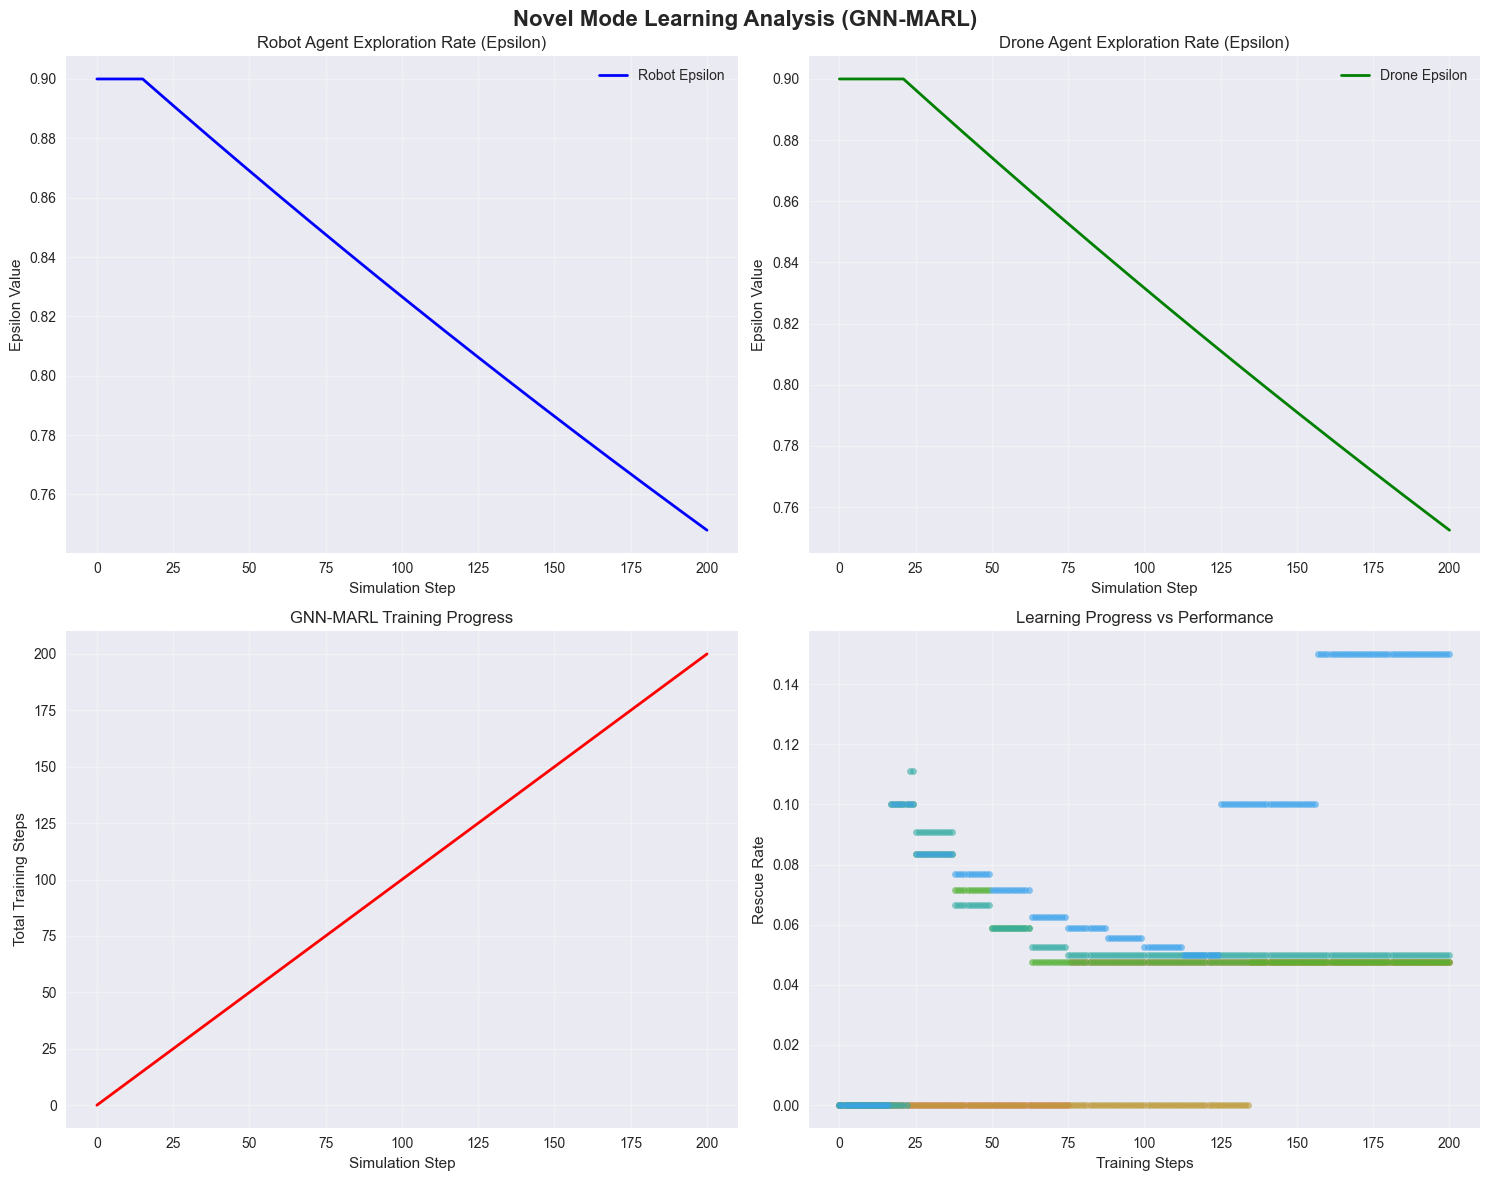


🧠 NOVEL MODE LEARNING ANALYSIS
Final robot exploration rate: 0.748
Final drone exploration rate: 0.752
Average training steps completed: 200
Final average performance: 0.069
Robot epsilon decay rate: 0.000757 per step

Average performance improvement: 0.069
✅ Novel Mode shows learning improvement over time


In [9]:
if NOVEL_MODE_AVAILABLE and not simulation_data.empty:
    # Filter data for Novel Mode only
    novel_data = simulation_data[simulation_data['Mode'] == 'novel']
    
    if not novel_data.empty:
        # Create figure for learning analysis
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Novel Mode Learning Analysis (GNN-MARL)', fontsize=16, fontweight='bold')
        
        # 1. Epsilon Decay for Robot Agents
        ax1 = axes[0, 0]
        robot_epsilon_stats = novel_data.groupby('Step')['Novel_Robot_Epsilon'].agg(['mean', 'std']).reset_index()
        
        ax1.plot(robot_epsilon_stats['Step'], robot_epsilon_stats['mean'], 
                label='Robot Epsilon', linewidth=2, color='blue')
        ax1.fill_between(robot_epsilon_stats['Step'], 
                        robot_epsilon_stats['mean'] - robot_epsilon_stats['std'], 
                        robot_epsilon_stats['mean'] + robot_epsilon_stats['std'], 
                        alpha=0.3, color='blue')
        
        ax1.set_xlabel('Simulation Step')
        ax1.set_ylabel('Epsilon Value')
        ax1.set_title('Robot Agent Exploration Rate (Epsilon)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Epsilon Decay for Drone Agents
        ax2 = axes[0, 1]
        drone_epsilon_stats = novel_data.groupby('Step')['Novel_Drone_Epsilon'].agg(['mean', 'std']).reset_index()
        
        ax2.plot(drone_epsilon_stats['Step'], drone_epsilon_stats['mean'], 
                label='Drone Epsilon', linewidth=2, color='green')
        ax2.fill_between(drone_epsilon_stats['Step'], 
                        drone_epsilon_stats['mean'] - drone_epsilon_stats['std'], 
                        drone_epsilon_stats['mean'] + drone_epsilon_stats['std'], 
                        alpha=0.3, color='green')
        
        ax2.set_xlabel('Simulation Step')
        ax2.set_ylabel('Epsilon Value')
        ax2.set_title('Drone Agent Exploration Rate (Epsilon)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Training Steps Progression
        ax3 = axes[1, 0]
        training_stats = novel_data.groupby('Step')['Novel_Training_Steps'].agg(['mean', 'std']).reset_index()
        
        ax3.plot(training_stats['Step'], training_stats['mean'], 
                linewidth=2, color='red')
        
        ax3.set_xlabel('Simulation Step')
        ax3.set_ylabel('Total Training Steps')
        ax3.set_title('GNN-MARL Training Progress')
        ax3.grid(True, alpha=0.3)
        
        # 4. Learning vs Performance Correlation
        ax4 = axes[1, 1]
        
        # Create scatter plot of training steps vs rescue rate
        for run_id in novel_data['Run_ID'].unique():
            run_data = novel_data[novel_data['Run_ID'] == run_id]
            ax4.scatter(run_data['Novel_Training_Steps'], run_data['Rescue Rate'], 
                       alpha=0.6, s=20, label=f'Run {run_id}')
        
        ax4.set_xlabel('Training Steps')
        ax4.set_ylabel('Rescue Rate')
        ax4.set_title('Learning Progress vs Performance')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Learning analysis summary
        print("\n🧠 NOVEL MODE LEARNING ANALYSIS")
        print("=" * 35)
        
        final_novel_data = novel_data.groupby('Run_ID').tail(1)
        
        avg_final_robot_epsilon = final_novel_data['Novel_Robot_Epsilon'].mean()
        avg_final_drone_epsilon = final_novel_data['Novel_Drone_Epsilon'].mean()
        avg_training_steps = final_novel_data['Novel_Training_Steps'].mean()
        avg_final_performance = final_novel_data['Rescue Rate'].mean()
        
        print(f"Final robot exploration rate: {avg_final_robot_epsilon:.3f}")
        print(f"Final drone exploration rate: {avg_final_drone_epsilon:.3f}")
        print(f"Average training steps completed: {avg_training_steps:.0f}")
        print(f"Final average performance: {avg_final_performance:.3f}")
        
        # Calculate learning rate (epsilon decay rate)
        initial_robot_epsilon = novel_data['Novel_Robot_Epsilon'].iloc[0]
        robot_decay_rate = (initial_robot_epsilon - avg_final_robot_epsilon) / len(novel_data['Step'].unique())
        
        print(f"Robot epsilon decay rate: {robot_decay_rate:.6f} per step")
        
        # Performance improvement analysis
        performance_improvement = []
        for run_id in novel_data['Run_ID'].unique():
            run_data = novel_data[novel_data['Run_ID'] == run_id].sort_values('Step')
            initial_perf = run_data['Rescue Rate'].iloc[:10].mean()  # First 10 steps
            final_perf = run_data['Rescue Rate'].iloc[-10:].mean()   # Last 10 steps
            improvement = final_perf - initial_perf
            performance_improvement.append(improvement)
        
        avg_improvement = np.mean(performance_improvement)
        print(f"\nAverage performance improvement: {avg_improvement:.3f}")
        
        if avg_improvement > 0:
            print("✅ Novel Mode shows learning improvement over time")
        else:
            print("📊 Novel Mode performance appears stable (minimal learning effect observed)")
    
    else:
        print("⚠️ No Novel Mode data available for learning analysis")
        
elif not NOVEL_MODE_AVAILABLE:
    print("⚠️ Novel Mode not available - skipping learning analysis")
    print("💡 Install PyTorch and torch-geometric to enable Novel Mode analysis")
else:
    print("❌ No simulation data available for learning analysis")

## Comparative Performance Summary

In [10]:
if not simulation_data.empty and len(summary_data['mode'].unique()) > 1:
    # Create comprehensive comparison table
    print("\n📋 COMPREHENSIVE PERFORMANCE COMPARISON")
    print("=" * 50)
    
    comparison_metrics = []
    
    for mode in summary_data['mode'].unique():
        mode_summary = summary_data[summary_data['mode'] == mode]
        mode_timeseries = simulation_data[simulation_data['Mode'] == mode]
        
        # Calculate comprehensive metrics
        metrics = {
            'Mode': mode.title(),
            'Avg_Rescued': mode_summary['rescued_final'].mean(),
            'Std_Rescued': mode_summary['rescued_final'].std(),
            'Avg_Rescue_Rate': mode_summary['rescue_rate_final'].mean(),
            'Std_Rescue_Rate': mode_summary['rescue_rate_final'].std(),
            'Avg_Messages': mode_summary['messages_total'].mean(),
            'Std_Messages': mode_summary['messages_total'].std(),
            'Messages_Per_Rescue': mode_summary['messages_total'].mean() / max(1, mode_summary['rescued_final'].mean()),
            'Avg_Dynamic_Spawns': mode_summary['persons_spawned_dynamically'].mean(),
        }
        
        # Add time-series derived metrics
        final_steps = mode_timeseries.groupby('Run_ID').tail(1)
        metrics['Avg_Active_Robots'] = final_steps['Active Robots'].mean()
        metrics['Avg_Robots_On_Mission'] = final_steps['Robots_On_Mission'].mean()
        metrics['Robot_Utilization'] = (final_steps['Robots_On_Mission'].mean() / 
                                       max(1, final_steps['Robots_On_Mission'].mean() + final_steps['Robots_Waiting'].mean())) * 100
        
        comparison_metrics.append(metrics)
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(comparison_metrics)
    
    # Display formatted table
    print("\n📊 Performance Metrics Comparison:")
    display(comparison_df.round(3))
    
    # Performance rankings
    print("\n🏆 PERFORMANCE RANKINGS")
    print("=" * 25)
    
    rankings = {
        'Rescue Efficiency': comparison_df.loc[comparison_df['Avg_Rescue_Rate'].idxmax(), 'Mode'],
        'Total Rescues': comparison_df.loc[comparison_df['Avg_Rescued'].idxmax(), 'Mode'],
        'Communication Efficiency': comparison_df.loc[comparison_df['Messages_Per_Rescue'].idxmin(), 'Mode'],
        'Robot Utilization': comparison_df.loc[comparison_df['Robot_Utilization'].idxmax(), 'Mode'],
    }
    
    for category, winner in rankings.items():
        print(f"{category}: {winner}")
    
    # Overall recommendation
    print("\n💡 OPERATIONAL RECOMMENDATIONS")
    print("=" * 32)
    
    extended_perf = comparison_df[comparison_df['Mode'] == 'Extended']
    novel_perf = comparison_df[comparison_df['Mode'] == 'Novel'] if 'Novel' in comparison_df['Mode'].values else None
    
    if novel_perf is not None and not novel_perf.empty:
        extended_rate = extended_perf['Avg_Rescue_Rate'].iloc[0]
        novel_rate = novel_perf['Avg_Rescue_Rate'].iloc[0]
        
        if novel_rate > extended_rate * 1.05:  # 5% improvement threshold
            print("🧠 Novel Mode (GNN-MARL) recommended for:")
            print("   - Complex, dynamic rescue scenarios")
            print("   - Long-term operations with learning benefits")
            print("   - High-stakes missions requiring optimal coordination")
            print("\n📡 Extended Mode recommended for:")
            print("   - Immediate deployment scenarios")
            print("   - Resource-constrained environments")
            print("   - Short-term operations")
        elif extended_rate > novel_rate * 1.05:
            print("📡 Extended Mode recommended for:")
            print("   - Most operational scenarios")
            print("   - Immediate deployment requirements")
            print("   - Resource-constrained environments")
            print("\n🧠 Novel Mode (GNN-MARL) may be considered for:")
            print("   - Research and development scenarios")
            print("   - Long-term learning optimization")
        else:
            print("⚖️ Both modes show comparable performance:")
            print("   - Choose Extended Mode for simplicity and reliability")
            print("   - Choose Novel Mode for advanced AI capabilities and learning")
    else:
        print("📡 Extended Mode provides enhanced communication and coordination")
        print("   compared to Basic Mode for mountain rescue operations.")
        
elif not simulation_data.empty:
    print("\n📊 Single mode analysis completed.")
    mode = simulation_data['Mode'].iloc[0]
    print(f"   {mode.title()} Mode performance validated successfully.")
else:
    print("❌ Insufficient data for performance comparison")


📋 COMPREHENSIVE PERFORMANCE COMPARISON

📊 Performance Metrics Comparison:


,Mode,Avg_Rescued,Std_Rescued,Avg_Rescue_Rate,Std_Rescue_Rate,Avg_Messages,Std_Messages,Messages_Per_Rescue,Avg_Dynamic_Spawns,Avg_Active_Robots,Avg_Robots_On_Mission,Robot_Utilization
0,Extended,6.4,0.894,0.308,0.041,21.8,3.493,3.406,12.8,3.6,0.4,12.5
1,Novel,1.4,0.894,0.069,0.046,8.2,11.256,5.857,12.6,4.0,0.0,0.0



🏆 PERFORMANCE RANKINGS
Rescue Efficiency: Extended
Total Rescues: Extended
Communication Efficiency: Extended
Robot Utilization: Extended

💡 OPERATIONAL RECOMMENDATIONS
📡 Extended Mode recommended for:
   - Most operational scenarios
   - Immediate deployment requirements
   - Resource-constrained environments

🧠 Novel Mode (GNN-MARL) may be considered for:
   - Research and development scenarios
   - Long-term learning optimization


## Export Results

In [11]:
# Export results to CSV files for further analysis
if not simulation_data.empty:
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Export detailed simulation data
    detailed_filename = f'mountain_rescue_detailed_analysis_{timestamp}.csv'
    simulation_data.to_csv(detailed_filename, index=False)
    print(f"📄 Detailed simulation data exported to: {detailed_filename}")
    
    # Export summary statistics
    summary_filename = f'mountain_rescue_summary_analysis_{timestamp}.csv'
    summary_data.to_csv(summary_filename, index=False)
    print(f"📄 Summary statistics exported to: {summary_filename}")
    
    # Create analysis report
    report_filename = f'mountain_rescue_analysis_report_{timestamp}.txt'
    
    with open(report_filename, 'w') as f:
        f.write("Mountain Rescue Simulation - KPI Analysis Report\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total Runs: {len(summary_data)}\n")
        f.write(f"Modes Tested: {', '.join(summary_data['mode'].unique())}\n")
        f.write(f"Steps per Run: {SIMULATION_CONFIG['steps_per_run']}\n\n")
        
        if len(summary_data['mode'].unique()) > 1:
            f.write("Performance Summary by Mode:\n")
            f.write("-" * 30 + "\n")
            
            for mode in summary_data['mode'].unique():
                mode_summary = summary_data[summary_data['mode'] == mode]
                f.write(f"\n{mode.title()} Mode:\n")
                f.write(f"  Average Rescue Rate: {mode_summary['rescue_rate_final'].mean():.3f} ± {mode_summary['rescue_rate_final'].std():.3f}\n")
                f.write(f"  Average Rescues: {mode_summary['rescued_final'].mean():.1f} ± {mode_summary['rescued_final'].std():.1f}\n")
                f.write(f"  Average Messages: {mode_summary['messages_total'].mean():.1f} ± {mode_summary['messages_total'].std():.1f}\n")
                f.write(f"  Messages per Rescue: {mode_summary['messages_total'].mean() / max(1, mode_summary['rescued_final'].mean()):.1f}\n")
        
        f.write("\nFiles Generated:\n")
        f.write(f"- {detailed_filename}\n")
        f.write(f"- {summary_filename}\n")
        f.write(f"- {report_filename}\n")
    
    print(f"📄 Analysis report exported to: {report_filename}")
    
    print(f"\n✅ Analysis complete! All results exported with timestamp {timestamp}")
else:
    print("❌ No data to export")

📄 Detailed simulation data exported to: mountain_rescue_detailed_analysis_20250715_140909.csv
📄 Summary statistics exported to: mountain_rescue_summary_analysis_20250715_140909.csv
📄 Analysis report exported to: mountain_rescue_analysis_report_20250715_140909.txt

✅ Analysis complete! All results exported with timestamp 20250715_140909


## Conclusion

This comprehensive KPI analysis provides insights into the relative performance of different operational modes in the Mountain Rescue Simulation:

### Key Findings:
1. **Rescue Efficiency**: Comparison of rescue rates and total persons saved
2. **Communication Effectiveness**: Analysis of message volume and efficiency
3. **Agent Coordination**: Evaluation of robot and drone utilization
4. **Learning Progress**: Novel Mode learning curves and improvement (if available)

### Applications:
- **Operational Planning**: Choose the most effective mode for specific scenarios
- **Resource Allocation**: Optimize agent deployment strategies
- **Performance Monitoring**: Track KPIs during actual operations
- **System Development**: Guide improvements to coordination algorithms

### Future Work:
- Extended simulation runs for more robust statistical analysis
- Variable scenario testing (different terrain, weather conditions)
- Real-time KPI monitoring dashboard development
- Integration with actual rescue operation data for validation